In [1]:
import numpy as np
import pandas as pd
from utils import load_data_local
import matplotlib.pyplot as plt

In [2]:
from scipy.spatial.distance import cdist
from itertools import groupby

## Set preferences

In [3]:
conditions = ['Safe Harbor KO', 'RASA2 KO', 'CUL5 KO']
colors = {'Safe Harbor KO': '#a9a9a9', 
          'RASA2 KO': '#800000',
          'CUL5 KO': '#000075'}


In [4]:
SH = ['B3', 'B4', 'B5', 'B6']
RASA2 = ['E3', 'E4', 'E5', 'E6']
CUL5 = ['B7', 'B8', 'B9', 'B10']

In [5]:
data_dir = '/gladstone/engelhardt/lab/MarsonLabIncucyteData/AnalysisFiles/CarnevaleRepStim/updated_full'

### Helper functions

In [6]:
def split(a):
    group = (n-i for i,n in enumerate(a))
    b     = [g for _,(*g,) in groupby(a,lambda _:next(group))]  
    return b
    
def get_x_y(well, len_scale = np.sqrt(900)): # given well, returns the average local t cell density for each cancer cell track and if the cell divided
    ob = load_data_local(data_dir + '/with_nuclei/cart_' + well + '_start_0_end_350_nuc_15_cyto_75.zip')
    div_df = pd.read_pickle(data_dir + '/with_nuclei/' + well + '_div.pkl')
    ts = load_data_local(data_dir + '/cart_' + well + '_start_0_end_350_nuc_15_cyto_75.zip')
    tcenters = np.load(data_dir + '/centroid-arrays/0_to_350/' + well + '-T-cells.npy')
    ncenters = np.load(data_dir + '/centroid-arrays/0_to_350/' + well + '-nuclei.npy')

    full_distances = np.zeros((350, len(ncenters), len(tcenters)))
    for i in range(350):
        full_distances[i] = cdist(ncenters[:,i], tcenters[:,i])
        
    y = []
    x = []
    rbf_scores = np.zeros((350, len(ncenters)))
    for i in range(350):
        rbf_scores[i] = np.nansum(np.exp(-np.square(full_distances[i]/len_scale)), axis = 1)
        
    for i in range(len(ncenters)):
        exists = np.where(~np.isnan(ncenters[i,:,0]))[0]
        consecutives = split(exists)
    
        parent_df = div_df[div_df['parent'] == i + 1]
        
        for tlist in consecutives:
            x.append(np.nanmean(rbf_scores[tlist, i]))
            if len(parent_df) > 0:
                
                has_divide = parent_df['frame'].values[0] - 1 in tlist
            else:
                has_divide = 0
            y.append(has_divide)
    return x, y

In [7]:
sh_s = [get_x_y(well) for well in SH]

In [8]:
rasa_s = [get_x_y(well) for well in RASA2]

In [9]:
cul_s = [get_x_y(well) for well in CUL5]

In [10]:
sh_x = np.concatenate([sh_s[i][0] for i in range(4)])
sh_y = np.concatenate([sh_s[i][1] for i in range(4)])

In [11]:
rasa_x = np.concatenate([rasa_s[i][0] for i in range(4)])
rasa_y = np.concatenate([rasa_s[i][1] for i in range(4)])

In [12]:
cul_x = np.concatenate([cul_s[i][0] for i in range(4)])
cul_y = np.concatenate([cul_s[i][1] for i in range(4)])

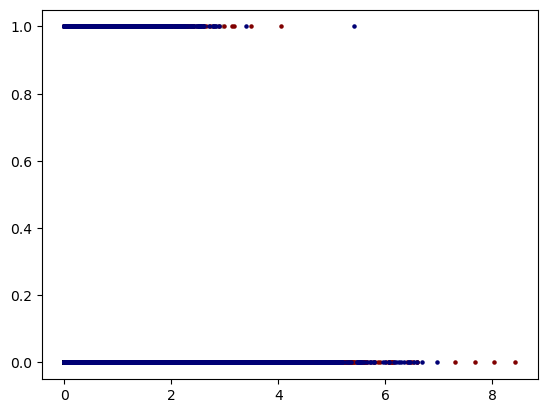

In [13]:
plt.scatter(sh_x, sh_y, label = 'Safe Harbor KO', c = colors['Safe Harbor KO'], s = 5)
plt.scatter(rasa_x, rasa_y, label = 'RASA2 KO', c = colors['RASA2 KO'], s = 5)
plt.scatter(cul_x, cul_y, label = 'CUL5 KO', c = colors['CUL5 KO'], s = 5)
plt.show()

### Fit model for each condition

In [14]:
import statsmodels.api as sm

In [15]:
sh_logit = sm.Logit(sh_y, sm.add_constant(sh_x))

In [16]:
sh_res = sh_logit.fit()

Optimization terminated successfully.
         Current function value: 0.113508
         Iterations 8


In [17]:
print(sh_res.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                52002
Model:                          Logit   Df Residuals:                    52000
Method:                           MLE   Df Model:                            1
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:               0.0005941
Time:                        13:14:33   Log-Likelihood:                -5902.6
converged:                       True   LL-Null:                       -5906.1
Covariance Type:            nonrobust   LLR p-value:                  0.008069
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6080      0.045    -80.034      0.000      -3.696      -3.520
x1            -0.1565      0.060     -2.599      0.009      -0.275      -0.039


In [18]:
rasa_logit = sm.Logit(rasa_y, sm.add_constant(rasa_x))
rasa_res = rasa_logit.fit()
print(rasa_res.summary())

Optimization terminated successfully.
         Current function value: 0.090988
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                69335
Model:                          Logit   Df Residuals:                    69333
Method:                           MLE   Df Model:                            1
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                0.005913
Time:                        13:14:35   Log-Likelihood:                -6308.6
converged:                       True   LL-Null:                       -6346.2
Covariance Type:            nonrobust   LLR p-value:                 4.591e-18
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6582      0.046    -80.109      0.000      -3.748      -3.569
x1            -0.3711      0.

In [19]:
cul_logit = sm.Logit(cul_y, sm.add_constant(cul_x))
cul_res = cul_logit.fit()
print(cul_res.summary())

Optimization terminated successfully.
         Current function value: 0.082709
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                65650
Model:                          Logit   Df Residuals:                    65648
Method:                           MLE   Df Model:                            1
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                0.007376
Time:                        13:14:36   Log-Likelihood:                -5429.8
converged:                       True   LL-Null:                       -5470.2
Covariance Type:            nonrobust   LLR p-value:                 2.630e-19
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6986      0.053    -70.031      0.000      -3.802      -3.595
x1            -0.4196      0.

### Plot logistic regression fit

In [20]:
bins = np.linspace(-1,1,9)
bar_x = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins) - 1)])

In [21]:
rasa_bin_y = np.zeros((len(bins) - 1))
cul_bin_y = np.zeros((len(bins) - 1))
sh_bin_y = np.zeros((len(bins) - 1))

In [22]:
width = bar_x[1] - bar_x[0]

In [23]:
for i in range(len(bins) - 1):
    low_lim = bins[i]
    upper_lim = bins[i+1]
    mask = np.logical_and(rasa_x > 10**low_lim, rasa_x < 10**upper_lim)
    rasa_pct = np.sum(rasa_y[mask])/np.sum(mask)
    rasa_bin_y[i] = rasa_pct
    mask = np.logical_and(cul_x > 10**low_lim, cul_x < 10**upper_lim)
    cul_bin_y[i] = np.sum(cul_y[mask])/np.sum(mask)
    mask = np.logical_and(sh_x > 10**low_lim, sh_x < 10**upper_lim)
    sh_bin_y[i] = np.sum(sh_y[mask])/np.sum(mask)

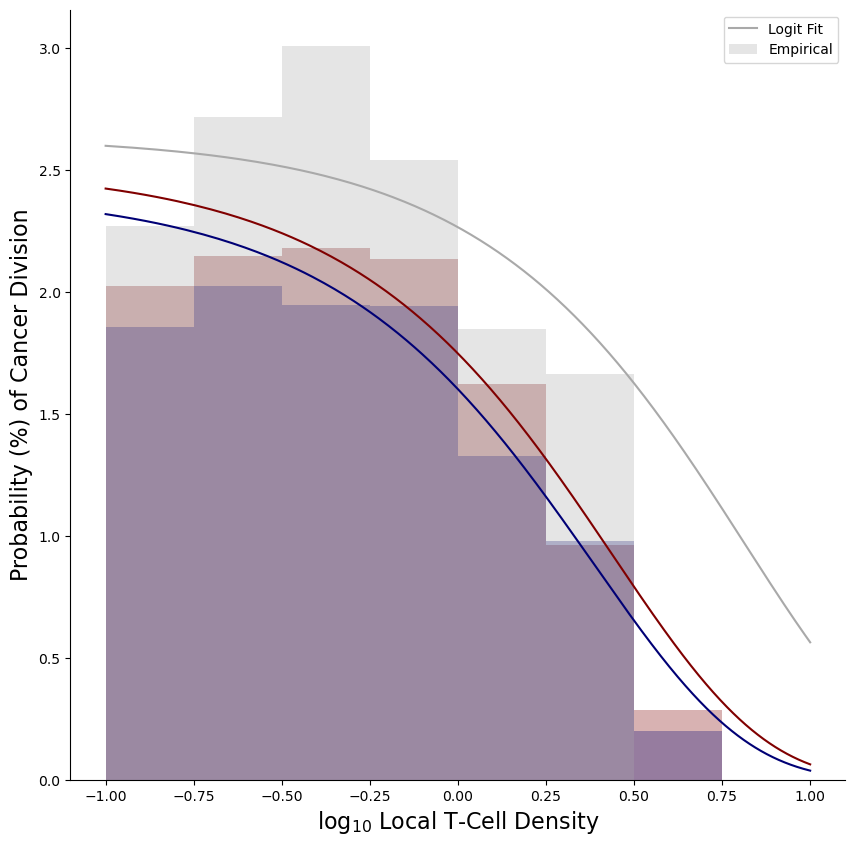

In [24]:
#plt.scatter(sh_x, sh_y, label = 'Safe Harbor KO', c = colors['Safe Harbor KO'], s = 5)
plot_x = np.linspace(0.1, 10, 1000)
plot_sh = sh_res.predict(sm.add_constant(plot_x))
plot_rasa = rasa_res.predict(sm.add_constant(plot_x))
plot_cul = cul_res.predict(sm.add_constant(plot_x))


fig, ax = plt.subplots(1,1,figsize = (10,10))
ax.plot(np.log10(plot_x), 100 * plot_sh, c = colors['Safe Harbor KO'], label = 'Logit Fit')
ax.plot(np.log10(plot_x), 100 * plot_rasa, c = colors['RASA2 KO'])
ax.plot(np.log10(plot_x), 100 * plot_cul, c = colors['CUL5 KO'])


ax.bar(bins[:-1], 100 * rasa_bin_y, color = colors['RASA2 KO'], alpha = 0.3, width = width, align = 'edge')
ax.bar(bins[:-1], 100 * cul_bin_y, color = colors['CUL5 KO'], alpha = 0.3, width = width, align = 'edge')
ax.bar(bins[:-1], 100 * sh_bin_y, color = colors['Safe Harbor KO'], alpha = 0.3, width = width, align = 'edge',
       label = 'Empirical')

ax.legend()

#plt.scatter(rasa_x, rasa_y, label = 'RASA2 KO', c = colors['RASA2 KO'], s = 5)
#plt.scatter(cul_x, cul_y, label = 'CUL5 KO', c = colors['CUL5 KO'], s = 5)
ax.set_xlabel('log$_{10}$ Local T-Cell Density', fontsize = 16)
ax.set_ylabel('Probability (%) of Cancer Division', fontsize = 16)
#ax.set_xscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.set_yscale('log')
#plt.savefig('./figs/fig2/division_spatial_effect_new.pdf', transparent = True)
plt.show()

### Combine each pair of two groups to test difference in slopes

In [25]:
rasa_sh_y = np.concatenate((sh_y, rasa_y))

In [26]:
rasa_sh_x = np.concatenate((sh_x, rasa_x))

In [27]:
rasa_sh_group = np.concatenate((np.zeros(sh_x.shape), np.ones(rasa_x.shape)))

In [28]:
rasa_sh_int = np.multiply(rasa_sh_x, rasa_sh_group)

In [29]:
X = np.vstack((rasa_sh_x, rasa_sh_group, rasa_sh_int, np.ones((rasa_sh_int.shape)))).T

In [30]:
rasa_sh_mod = sm.Logit(rasa_sh_y, X)
rasa_sh_res = rasa_sh_mod.fit()
print(rasa_sh_res.summary())

Optimization terminated successfully.
         Current function value: 0.100639
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               121337
Model:                          Logit   Df Residuals:                   121333
Method:                           MLE   Df Model:                            3
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                0.005287
Time:                        13:14:39   Log-Likelihood:                -12211.
converged:                       True   LL-Null:                       -12276.
Covariance Type:            nonrobust   LLR p-value:                 5.953e-28
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1565      0.060     -2.599      0.009      -0.275      -0.039
x2            -0.0502      0.

In [31]:
rasa_sh_res.pvalues

array([0.00933621, 0.4343213 , 0.00444766, 0.        ])

In [32]:
cul_sh_y = np.concatenate((sh_y, cul_y))
cul_sh_x = np.concatenate((sh_x, cul_x))
cul_sh_group = np.concatenate((np.zeros(sh_x.shape), np.ones(cul_x.shape)))
cul_sh_int = np.multiply(cul_sh_x, cul_sh_group)
X = np.vstack((cul_sh_x, cul_sh_group, cul_sh_int, np.ones((cul_sh_int.shape)))).T
cul_sh_mod = sm.Logit(cul_sh_y, X)
cul_sh_res = cul_sh_mod.fit()
print(cul_sh_res.summary())

Optimization terminated successfully.
         Current function value: 0.096322
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               117652
Model:                          Logit   Df Residuals:                   117648
Method:                           MLE   Df Model:                            3
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                0.007778
Time:                        13:14:40   Log-Likelihood:                -11332.
converged:                       True   LL-Null:                       -11421.
Covariance Type:            nonrobust   LLR p-value:                 2.798e-38
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1565      0.060     -2.599      0.009      -0.275      -0.039
x2            -0.0906      0.

In [33]:
cul_sh_res.pvalues

array([0.00933621, 0.19217571, 0.00073838, 0.        ])

In [34]:
cul_rasa_y = np.concatenate((rasa_y, cul_y))
cul_rasa_x = np.concatenate((rasa_x, cul_x))
cul_rasa_group = np.concatenate((np.zeros(rasa_x.shape), np.ones(cul_x.shape)))
cul_rasa_int = np.multiply(cul_rasa_x, cul_rasa_group)
X = np.vstack((cul_rasa_x, cul_rasa_group, cul_rasa_int, np.ones((cul_rasa_int.shape)))).T
cul_rasa_mod = sm.Logit(cul_rasa_y, X)
cul_rasa_res = cul_rasa_mod.fit()
print(cul_rasa_res.summary())

Optimization terminated successfully.
         Current function value: 0.086961
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               134985
Model:                          Logit   Df Residuals:                   134981
Method:                           MLE   Df Model:                            3
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                0.006934
Time:                        13:14:42   Log-Likelihood:                -11738.
converged:                       True   LL-Null:                       -11820.
Covariance Type:            nonrobust   LLR p-value:                 2.609e-35
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3711      0.045     -8.165      0.000      -0.460      -0.282
x2            -0.0404      0.

In [35]:
cul_rasa_res.pvalues

array([3.21758101e-16, 5.62920761e-01, 4.70724217e-01, 0.00000000e+00])